In [1]:
%matplotlib inline
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import librosa
import IPython.display as ipd
import librosa.display
from scipy.io import wavfile
import sklearn as sk
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
import soundfile as sf

# Загружаем аудио

In [2]:
files = [f for f in os.listdir('../../Test003/SF1/') if os.path.isfile(f) and f.endswith(".wav")]
print(files)

['002.wav', '003.wav', '004.wav']


In [3]:
c=[os.path.abspath(files[0])]
print(c)

['C:\\Users\\Alexandra\\Test003\\SF — копия (2) — копия\\002.wav']


# Делим дорожку на кадры

In [66]:
frame_length=15433
hop_length=500
frame = []
frame1=[]
for i in range(len(files)): 
    y , sr = librosa.load(files[i])
    frame1.append(librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length))

In [67]:
frame=np.hstack((frame1))

In [68]:
len(frame[0])

2602

In [69]:
frame[0,3]

0.00019233007

In [70]:
#y , sr = librosa.load(files[0])
#frame1=librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)

In [71]:
#len(frame1[0])

In [72]:
#frame1[0,3]

In [59]:
#frame_length=15433
#hop_length=500
#frame = []
#for i in range(len(files)): 
#    y , sr = librosa.load(files[i])
#    frame=np.vstack(librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length))

# Загружаем метки

Metki = [f for f in os.listdir('../../Test003/SF1/') if os.path.isfile(f) and f.endswith(".txt")]
metki = []
for i in range(len(Metki)): 
    m=np.hstack(np.genfromtxt(Metki[i]))
    metki.append(m)

In [78]:
Metki = [f for f in os.listdir('../../Test003/SF1/') if os.path.isfile(f) and f.endswith(".txt")]
metki = []
for i in range(len(Metki)): 
    metki.append(np.genfromtxt(Metki[i],dtype='str'))

In [95]:
metki=np.vstack(metki)

In [96]:
len(metki[0])

2

In [97]:
metki[11,1]

'5.876366'

In [90]:
#Metki = [f for f in os.listdir('../../Test003/SF1/') if os.path.isfile(f) and f.endswith(".txt")]
#metki1 = []
#metki2 = []
#for i in range(len(Metki)): 
#    m=np.genfromtxt(Metki[i],dtype='str')
#    metki1.append(m[i,0])
#   metki2.append(m[i,1])

In [91]:
#metki1=np.array(metki1)
#metki2=np.array(metki2)
#metki1 = metki1.reshape(-1,1)
#metki2 = metki2.reshape(-1,1)

In [92]:
#metki=np.hstack((metki1, metki2)).reshape(-1, 2)

In [93]:
#metki[0,1]

In [94]:
times_frame=frame_length/sr                      #Сколько в секунде кадров
times_hop=(hop_length/sr)                        #Сколько в секунде прыжков

Делим аудио по времени на кадры.

In [101]:
times = []
for i in range(len(frame[0])):
    times.append([times_hop*i,times_frame+times_hop*i])        
#print(times)

Загружаем в таблицу

In [99]:
%%time
df = pd.DataFrame(columns = ['mfccs','frames','event_label'])
m = times
for mark in m:
    df = df.append({'frames':(mark[0],mark[1])},ignore_index=True)
print(df)

     mfccs                                      frames event_label
0      NaN                   (0.0, 0.6999092970521542)         NaN
1      NaN  (0.022675736961451247, 0.7225850340136054)         NaN
2      NaN  (0.045351473922902494, 0.7452607709750567)         NaN
3      NaN   (0.06802721088435373, 0.7679365079365079)         NaN
4      NaN   (0.09070294784580499, 0.7906122448979592)         NaN
...    ...                                         ...         ...
2597   NaN     (58.888888888888886, 59.58879818594104)         NaN
2598   NaN      (58.91156462585034, 59.61147392290249)         NaN
2599   NaN     (58.93424036281179, 59.634149659863944)         NaN
2600   NaN      (58.956916099773245, 59.6568253968254)         NaN
2601   NaN      (58.97959183673469, 59.67950113378684)         NaN

[2602 rows x 3 columns]
Wall time: 19.3 s


# Смотрим попала ли метка в кадр

In [102]:
block = np.zeros((len(frame[0])), dtype=int)
for i,mark in enumerate(times):   
    for j in range(len(metki)):    
        if (mark[0]) <= float(metki[j,0]) <= (mark[1]) and (mark[0]) <= float(metki[j,1]) <= (mark[1]):
            block[i]=1
#print(block)

In [105]:
df['event_label'] = block
df.head()

,mfccs,frames,event_label
0,NaN,"(0.0, 0.6999092970521542)",0
1,NaN,"(0.022675736961451247, 0.7225850340136054)",0
2,NaN,"(0.045351473922902494, 0.7452607709750567)",0
3,NaN,"(0.06802721088435373, 0.7679365079365079)",0
4,NaN,"(0.09070294784580499, 0.7906122448979592)",0


In [106]:
df["event_label"].value_counts()

0    2207
1     395
Name: event_label, dtype: int64

# Кепстральные коэффициенты Mel-частоты (MFCC)

# Нормируем данные

In [13]:
#данные не нормированные и нормированные 10 глотков.
mfccs_1=librosa.feature.mfcc(y=y, sr=sr, hop_length=512, htk=True, n_mfcc=15,dct_type = 2,norm = 'ortho')
mfccs_new = sk.preprocessing.scale(mfccs_1, axis=1, with_mean= True, with_std= True, copy=True)
#print(mfccs_new.mean(), mfccs_new.min(),mfccs_new.max(),mfccs_new.std())

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


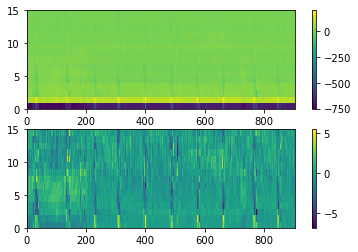

In [14]:
plt.subplot(2,1,1)
plt.pcolormesh(mfccs_1[:,:])
plt.colorbar()
plt.subplot(2,1,2)
plt.pcolormesh(mfccs_new[:,:])
plt.colorbar()
plt.show()

In [15]:
#нормируем все кадры
frames_norm = sk.preprocessing.scale(frames, axis=1, with_mean= True, with_std= True, copy=True)
print(frames_norm.mean(),frames_norm.min(),frames_norm.max(),frames_norm.std())

1.974113e-09 -19.85645 22.303673 1.0


D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [147]:
mfccs2=librosa.feature.mfcc(y=frames[:,0], sr=sr, hop_length=512, htk=True, n_mfcc=15,dct_type = 2,norm = 'ortho')

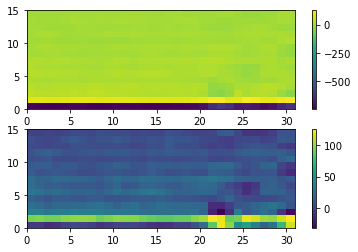

In [17]:
plt.subplot(2,1,1)
plt.pcolormesh(mfccs2[:,:])
plt.colorbar()
plt.subplot(2,1,2)
plt.pcolormesh(mfccs1[:,:])
plt.colorbar()
plt.show()

Делим коэффициенты на кадры

In [165]:
mfccs1 = []
for i in range(len(frames[0])):   
    mfccs1.append(librosa.feature.mfcc(y=frames[:,i], sr=sr, hop_length=512, htk=True, n_mfcc=15,dct_type = 2,norm = None))

Нормируем все коэффициенты

In [167]:
mfccs = []
for i in range(len(frames[0])):   
    mfccs.append(sk.preprocessing.scale(mfccs1[i], axis=1, with_mean= True, with_std= True, copy=True))

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues 

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountere

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues 

Переводим в одномерный массив

In [168]:
MFCCS = []
for i in range(len(frames[0])): 
    MFCCS.append(mfccs[i].flatten())
#    print(MFCCS[0])

In [169]:
MFCCS=np.array(MFCCS, dtype=float)
#MFCCS.shape

In [170]:
df['mfccs'] = list(MFCCS)
#df.head()

# Кратковременное преобразование Фурье (STFT).

In [178]:
stft1 = []
for i in range(len(frames[0])):   
    stft1.append(librosa.stft(y=frames[:,i], n_fft = 512, hop_length = 500, win_length = None, window = 'hann', center = True, dtype = None, pad_mode = 'reflect'))

In [192]:
stft2 = []
for i in range(len(frames[0])): 
    stft2.append(stft1[i].astype(np.float32))

<ipython-input-192-9b7e0eff9cae>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  stft2.append(stft1[i].astype(np.float32))


In [193]:
stft = []
for i in range(len(frames[0])):   
    stft.append(sk.preprocessing.scale(stft2[i], axis=1, with_mean= True, with_std= True, copy=True))

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling 

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling 

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling 

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling 

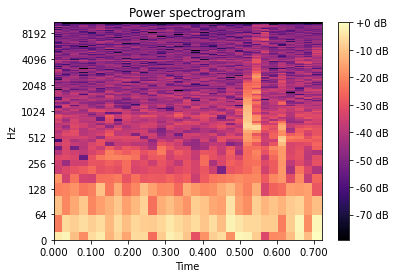

In [197]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(stft1[0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

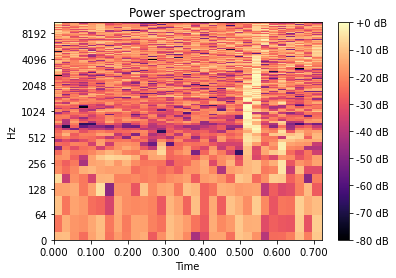

In [198]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(stft[0],
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [199]:
STFT = []
for i in range(len(frames[0])): 
    STFT.append(stft[i].flatten())

In [200]:
STFT=np.array(STFT, dtype=float)
#print(STFT[0])
STFT.shape

(896, 7967)

In [201]:
#x_df = STFT
#y_df = block

# Вейвлет-преобразование 

In [202]:
import pywt

In [203]:
#Возвращает список доступных встроенных семейств вейвлетов.
#Хаар ( haar )
#Добеши ( db )
#Symlets ( sym )
#Койфлеты ( coif )
#Биортогональный ( bior )
#Обратный биортогональный ( rbio )
#«Дискретное» FIR-приближение вейвлета Мейера ( dmey )
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [204]:
print(pywt.wavelist( 'dmey'))

['dmey']


In [205]:
wavelet = pywt.Wavelet('dmey')
print(wavelet)

Wavelet dmey
  Family name:    Discrete Meyer (FIR Approximation)
  Short name:     dmey
  Filters length: 62
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       symmetric
  DWT:            True
  CWT:            False


In [34]:
cA1, cD1  = pywt.dwt(frames[0], wavelet , mode='symmetric', axis=-1)
#plt.plot(cA1)
#plt.plot(cD1)
plt.show()

In [36]:
#wavelet.filter_bank
#(w.dec_lo, w.dec_hi, w.rec_lo, w.rec_hi) 

In [207]:
waveletcA = []
waveletcD = []
for i in range(len(frames[0])):  
    cA, cD  = pywt.dwt(frames[:,i], wavelet , mode='symmetric', axis=-1)
    waveletcA.append(cA)
    waveletcD.append(cD)

In [217]:
waveletCA = []
waveletCD = []
for i in range(len(frames[0])):   
    waveletCA.append(sk.preprocessing.scale(waveletcA[i], axis=0, with_mean= True, with_std= True, copy=True))
    waveletCD.append(sk.preprocessing.scale(waveletcD[i], axis=0, with_mean= True, with_std= True, copy=True))

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling 

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling 

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling 

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling 

D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
D:\Alexandra\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling 

In [228]:
waveletCA=np.array(waveletCA, dtype=float)
#print(waveletCA[0])
waveletCD=np.array(waveletCD, dtype=float)
#print(waveletCD[0])
waveletCA.shape,waveletCD.shape

((896, 7747), (896, 7747))

In [40]:
#x_df = waveletCA
#y_df = block

In [41]:
#x_df = waveletCD
#y_df = block

# Делим на обучающую и тестовую выборки и обучаем

In [42]:
x_df = MFCCS

In [43]:
y_df = block

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn import tree
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz

Видим, что выборка несбалонсированна. 

In [45]:
x_train, x_valid, y_train, y_valid = train_test_split(x_df,y_df, test_size=0.3, random_state=17)

In [46]:
np.count_nonzero(y_valid == 1)

58

In [47]:
np.count_nonzero(y_valid == 0)

211

In [48]:
 np.count_nonzero(y_train == 1)

168

In [49]:
np.count_nonzero(y_train == 0)

459

# Нейронная сеть

In [50]:
import tensorflow as tf
from tensorflow import keras
from  tensorflow.keras import layers

In [51]:
r=len(x_train)
u=len(x_train[0])
print(u,r)

465 627


In [52]:
x_train.shape

(627, 465)

In [53]:
model = tf.keras.Sequential([                                       #Sequential группирует линейную стопку слоев в tf.keras.Model.
    tf.keras.layers.Flatten(input_shape=(u,)),                      #преобразует матрицу ввода в единый массив.
#   tf.keras.layers.Dense(128, kernel_initializer='orthogonal'),    #генерирует случайные веса
    tf.keras.layers.Dense(128, activation=tf.nn.relu),              #Применяет функцию активации выпрямленного линейного блока.   
#Схемы регуляризации добавляемые к весам слоя (ядро и сдвиг), такие как L1 или L2 регуляризации.
#kernel_regularizer : функция регуляризатора, применяемая к матрице весов ядра.
#bias_regularizer : функция регуляризатора, применяемая к вектору смещения.
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l1(0.01)),
    tf.keras.layers.Dense(64, bias_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax),   #2 категории 0 и 1; преобразует вектор значений в распределение вероятностей
])

In [54]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
20/20 [==============================] - 0s 1ms/step - loss: 81.7459 - accuracy: 0.8293
Epoch 2/5
20/20 [==============================] - 0s 1ms/step - loss: 20.8294 - accuracy: 0.9426
Epoch 3/5
20/20 [==============================] - 0s 1ms/step - loss: 14.9960 - accuracy: 0.9761
Epoch 4/5
20/20 [==============================] - 0s 1ms/step - loss: 14.5072 - accuracy: 0.9745
Epoch 5/5
20/20 [==============================] - 0s 2ms/step - loss: 14.0411 - accuracy: 0.9809


In [56]:
test_loss, test_acc = model.evaluate(x_valid, y_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

9/9 [==============================] - 0s 873us/step - loss: 11.9854 - accuracy: 0.9814
Test accuracy: 0.9814126491546631
Test loss: 11.985406875610352


In [57]:
predictions = model.predict(x_valid)

# Сверточная нейронная сеть

In [58]:
x_cnn_df = mfccs
y_cnn_df = block

In [59]:
x_cnn_train, x_cnn_valid, y_cnn_train, y_cnn_valid = train_test_split(x_cnn_df,y_cnn_df, test_size=0.3, random_state=17)

In [60]:
x_cnn_train=np.array(x_cnn_train)
x_cnn_valid=np.array(x_cnn_valid)

In [61]:
model = tf.keras.Sequential([    
    tf.keras.layers.Conv1D(64, kernel_size = 3, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size = 3, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(input_shape=()),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)   
])

In [62]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [63]:
model.fit(x_cnn_train, y_cnn_train, epochs=5)

Epoch 1/5
20/20 [==============================] - 0s 2ms/step - loss: 11.2046 - accuracy: 0.8724
Epoch 2/5
20/20 [==============================] - 0s 2ms/step - loss: 2.3026 - accuracy: 0.9697
Epoch 3/5
20/20 [==============================] - 0s 2ms/step - loss: 0.9572 - accuracy: 0.9777
Epoch 4/5
20/20 [==============================] - 0s 2ms/step - loss: 1.8979 - accuracy: 0.9761
Epoch 5/5
20/20 [==============================] - 0s 2ms/step - loss: 0.3125 - accuracy: 0.9872


In [64]:
test_loss, test_acc = model.evaluate(x_cnn_valid, y_cnn_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

9/9 [==============================] - 0s 815us/step - loss: 1.8859 - accuracy: 0.9740
Test accuracy: 0.9739776849746704
Test loss: 1.8859072923660278


Вейвлет

In [233]:
waveletcad = []
for i in range(len(frames[0])):  
    cad  = pywt.dwt(frames[:,i], wavelet , mode='symmetric', axis=-1)
    waveletcad.append(cad)

In [236]:
waveletcAD = []
for i in range(len(frames[0])):   
    waveletcAD.append(sk.preprocessing.scale(waveletcad[i], axis=0, with_mean= True, with_std= True, copy=True))

In [237]:
waveletcAD=np.array(waveletcAD, dtype=float)
#print(waveletCA[0])
waveletcAD.shape

(896, 2, 7747)

In [238]:
x_cnn_df = waveletcAD
y_df=block

In [239]:
x_cnn_train, x_cnn_valid, y_cnn_train, y_cnn_valid = train_test_split(x_cnn_df,y_df, test_size=0.3, random_state=17)

In [240]:
model2 = tf.keras.Sequential([    
    tf.keras.layers.Conv1D(128, kernel_size = 1, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=1,padding='same'),
    tf.keras.layers.Conv1D(128, kernel_size = 1, activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=1,padding='same'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax),   
    tf.keras.layers.Flatten(input_shape=())
    ])

In [241]:
model2.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [242]:
model2.fit(x_cnn_train, y_cnn_train, epochs=5)

Epoch 1/5
20/20 [==============================] - 2s 27ms/step - loss: 1.8071 - accuracy: 0.3285
Epoch 2/5
20/20 [==============================] - 0s 25ms/step - loss: 1.0216 - accuracy: 0.5247
Epoch 3/5
20/20 [==============================] - 0s 24ms/step - loss: 0.8022 - accuracy: 0.6507
Epoch 4/5
20/20 [==============================] - 0s 24ms/step - loss: 0.7207 - accuracy: 0.7081
Epoch 5/5
20/20 [==============================] - 0s 24ms/step - loss: 0.6987 - accuracy: 0.7368


In [243]:
test_loss, test_acc = model2.evaluate(x_cnn_valid, y_cnn_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

9/9 [==============================] - 0s 5ms/step - loss: 1.9169 - accuracy: 0.4126
Test accuracy: 0.41263940930366516
Test loss: 1.9169327020645142


# Дерево решений

Обучаем модель

In [74]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=17)

Оценка модели

In [75]:
tree_pred = tree.predict(x_valid)
accuracy_score(y_valid, tree_pred) 

0.9219330855018587

ROC-кривая (англ. receiver operating characteristic, рабочая характеристика приёмника) — график, позволяющий оценить
качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака,
верно классифицированных как несущие признак (англ. true positive rate, TPR, называемой чувствительностью алгоритма
классификации), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных
как несущие признак (англ. false positive rate, FPR, величина 1-FPR называется специфичностью алгоритма классификации) 
при варьировании порога решающего правила.

Также известна как кривая ошибок. Анализ классификаций с применением ROC-кривых называется ROC-анализом.

Количественная интерпретация ROC даёт показатель AUC (англ. Area Under Curve, площадь под кривой) — площадь, ограниченная
ROC-кривой и осью доли ложных положительных классификаций. Чем выше показатель AUC, тем качественнее классификатор, 
при этом значение 0,5 демонстрирует непригодность выбранного метода классификации (соответствует случайному гаданию).
Значение менее 0,5 говорит, что классификатор действует с точностью до наоборот: если положительные назвать отрицательными
и наоборот, классификатор будет работать лучше.

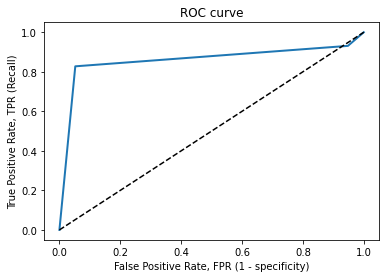

In [76]:
fpr, tpr, thresholds = roc_curve(y_valid, tree.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно 
являющимися положительными, а recall показывает, какую долю объектов положительного класса из всех объектов положительного
класса нашел алгоритм. Precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы 
в условиях несбалансированных выборок.

F-мера достигает максимума при максимальной полноте и точности, и близка к нулю, если один из аргументов близок к нулю. 
F-мера является хорошим кандидатом на формальную метрику оценки качества классификатора. 
Она сводит к одному числу две других основополагающих метрики: точность и полноту. 
Имея "F-меру" гораздо проще ответить на вопрос: "поменялся алгоритм в лучшую сторону или нет?"

In [77]:
report = classification_report(y_valid, tree.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       211
           1       0.81      0.83      0.82        58

    accuracy                           0.92       269
   macro avg       0.88      0.89      0.89       269
weighted avg       0.92      0.92      0.92       269



# Настроим параметры модели

In [78]:
tree_params = {'max_depth': range(1,11),'max_features': range(1,19)}

In [79]:
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

In [80]:
tree_grid.fit(x_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 848 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    3.5s finished


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(1, 19)},
             verbose=True)

In [81]:
tree_grid.best_score_,tree_grid.best_params_

(0.952152380952381, {'max_depth': 5, 'max_features': 16})

In [82]:
accuracy_score(y_valid, tree_grid.predict(x_valid))

0.9182156133828996

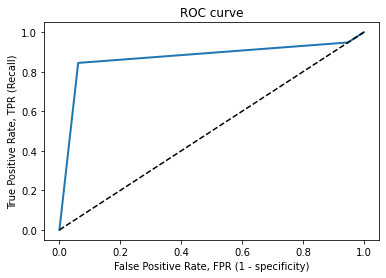

In [83]:
fpr, tpr, thresholds = roc_curve(y_valid, tree_grid.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [84]:
report = classification_report(y_valid, tree_grid.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       211
           1       0.79      0.84      0.82        58

    accuracy                           0.92       269
   macro avg       0.87      0.89      0.88       269
weighted avg       0.92      0.92      0.92       269



# Метод ближайших соседей

Обучаем модель

In [85]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

Оценка модели

In [86]:
knn_pred = knn.predict(x_valid)
accuracy_score(y_valid, knn_pred) 

0.9553903345724907

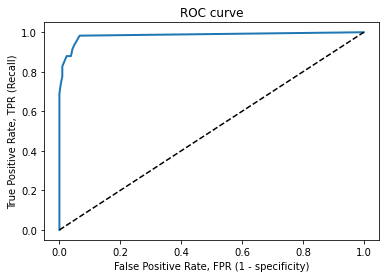

In [87]:
fpr, tpr, thresholds = roc_curve(y_valid, knn.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [88]:
report = classification_report(y_valid, knn.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       211
           1       0.96      0.83      0.89        58

    accuracy                           0.96       269
   macro avg       0.96      0.91      0.93       269
weighted avg       0.96      0.96      0.95       269



Настроим параметры модели

In [89]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [90]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [91]:
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, n_jobs=-1, verbose=True)

In [92]:
knn_grid.fit(x_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    0.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [93]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 1}, 0.9776761904761905)

In [94]:
accuracy_score(y_valid, knn_grid.predict(x_valid))

0.9702602230483272

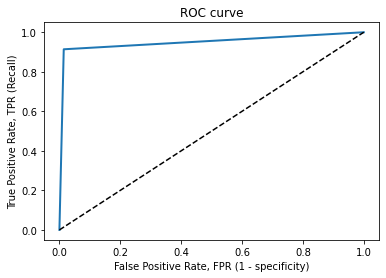

In [95]:
fpr, tpr, thresholds = roc_curve(y_valid, knn_grid.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [96]:
report = classification_report(y_valid, knn_grid.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       211
           1       0.95      0.91      0.93        58

    accuracy                           0.97       269
   macro avg       0.96      0.95      0.96       269
weighted avg       0.97      0.97      0.97       269



# Случайный лес

In [97]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, x_train, y_train, cv=5))) 

0.9872380952380952


In [98]:
forest_params = {'max_depth': range(1,11), 'max_features': range(1,19)}

In [99]:
forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)

In [100]:
forest_grid.fit(x_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.5min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(1, 19)},
             verbose=True)

In [101]:
forest_grid.best_params_, forest_grid.best_score_ 

({'max_depth': 6, 'max_features': 18}, 0.9888380952380953)

In [102]:
accuracy_score(y_valid, forest_grid.predict(x_valid))

0.9702602230483272

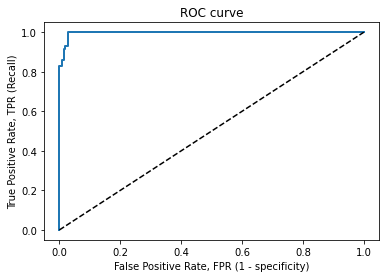

In [103]:
fpr, tpr, thresholds = roc_curve(y_valid, forest_grid.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [104]:
report = classification_report(y_valid, forest_grid.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       211
           1       0.95      0.91      0.93        58

    accuracy                           0.97       269
   macro avg       0.96      0.95      0.96       269
weighted avg       0.97      0.97      0.97       269



# Логистическая регрессия 

In [105]:
model = LogisticRegression(solver='liblinear', random_state=0)

In [106]:
model.fit(x_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [107]:
#LogisticRegression(
#    C=1.0, 
#    class_weight=None, 
#    dual=False, 
#    fit_intercept=True,
#    intercept_scaling=1, 
#    l1_ratio=None, 
#    max_iter=100,
#    multi_class='warn', 
#    n_jobs=None, 
#    penalty='l2',
#    random_state=0, 
#    solver='liblinear', 
#    tol=0.0001, 
#    verbose=0,
#    warm_start=False
#)

In [108]:
model = LogisticRegression(solver='liblinear', random_state=0).fit(x_train, y_train)

In [109]:
#Это пример двоичной классификации, и y может быть 0 или 1
model.classes_

array([0, 1])

In [110]:
#Можно получить значение наклона b1 и точку пересечения b0 линейной функции f следующим образом
#b0 задается внутри одномерного массива, а b1 — внутри двумерного массива
model.intercept_
model.coef_

array([[-6.90464263e-03, -7.76811575e-04,  3.91428349e-04,
        -2.27068701e-03, -2.42660692e-03,  1.14997226e-03,
        -4.33532723e-04, -8.04536160e-04,  2.53935994e-03,
         3.13950919e-03, -3.84985105e-04,  1.27694547e-03,
         1.92496276e-03, -9.25246100e-04,  1.68229243e-03,
         1.82838096e-03,  2.74842917e-04,  1.47109400e-03,
         1.18359835e-03,  1.15128479e-03,  1.91111561e-03,
         2.04173729e-03,  4.18120728e-04,  2.05572837e-03,
         8.74482463e-04,  1.44158699e-03,  2.39172383e-03,
         2.70561488e-03, -1.13613558e-03, -1.45313490e-03,
        -2.96090032e-04,  1.25989622e-04,  2.47287876e-03,
         2.09371963e-03,  1.67314761e-03,  3.32611207e-04,
         1.03006438e-03,  1.21128318e-03,  1.91131453e-03,
        -1.69350232e-04, -1.29725130e-04,  2.46531657e-04,
        -6.34157919e-05, -7.73781825e-04, -4.88962333e-04,
        -1.28821187e-03, -4.07168028e-04, -6.68229423e-06,
        -6.16841353e-05,  1.52364120e-04,  5.74937278e-0

In [111]:
#Первый столбец — это вероятность того, что прогнозируемый результат будет равен нулю, то есть 1−p(x).
#Второй столбец — это вероятность того, что на выходе будет единица или p(x).
model.predict_proba(x_valid)

array([[9.99996116e-01, 3.88424488e-06],
       [9.99999996e-01, 4.37074508e-09],
       [1.00000000e+00, 4.72928116e-10],
       [9.99999613e-01, 3.86709943e-07],
       [1.00000000e+00, 3.12315070e-13],
       [1.00000000e+00, 6.67363465e-13],
       [1.00000000e+00, 1.07837353e-10],
       [8.88178420e-15, 1.00000000e+00],
       [9.99999981e-01, 1.87589259e-08],
       [9.99924807e-01, 7.51933216e-05],
       [8.86391127e-01, 1.13608873e-01],
       [7.59249774e-10, 9.99999999e-01],
       [9.97662788e-01, 2.33721173e-03],
       [1.00000000e+00, 6.84642686e-14],
       [1.00000000e+00, 1.41853436e-12],
       [1.00000000e+00, 5.95184402e-17],
       [1.00000000e+00, 5.80891158e-13],
       [9.99950081e-01, 4.99193386e-05],
       [9.99999902e-01, 9.75730979e-08],
       [1.00000000e+00, 3.01569736e-17],
       [9.99999985e-01, 1.45768224e-08],
       [1.00000000e+00, 1.14992962e-10],
       [6.35911324e-11, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.999995

In [112]:
#Фактические прогнозы
model.predict(x_valid)

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0])

In [113]:
model.score(x_valid, y_valid)

0.966542750929368

In [114]:
#Чтобы создать матрицу ошибок, вы можете использовать confusion_matrix() и предоставить
#фактические и прогнозируемые результаты в качестве аргументов:
confusion_matrix(y_valid, model.predict(x_valid))

array([[206,   5],
       [  4,  54]], dtype=int64)

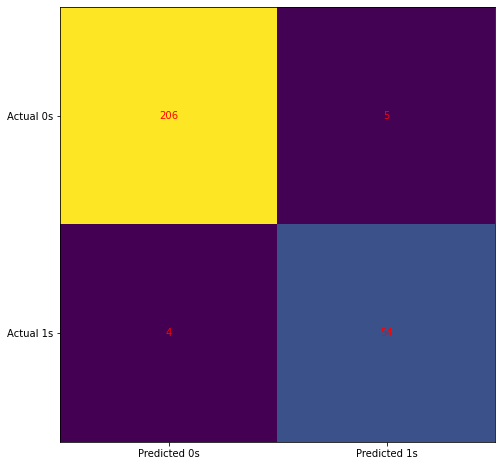

In [115]:
cm = confusion_matrix(y_valid, model.predict(x_valid))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

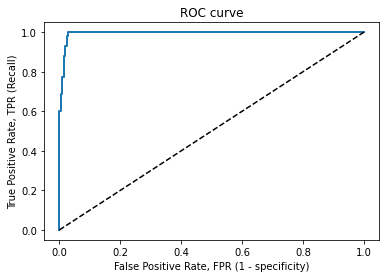

In [116]:
fpr, tpr, thresholds = roc_curve(y_valid, model.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [117]:
report = classification_report(y_valid, model.predict(x_valid), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       211
           1       0.92      0.93      0.92        58

    accuracy                           0.97       269
   macro avg       0.95      0.95      0.95       269
weighted avg       0.97      0.97      0.97       269



In [118]:
print(classification_report(y_valid, model.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       211
           1       0.92      0.93      0.92        58

    accuracy                           0.97       269
   macro avg       0.95      0.95      0.95       269
weighted avg       0.97      0.97      0.97       269



# Улучшенная модель логистической регрессии Попытка провалилась (C=10.0)

In [119]:
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
model.fit(x_train, y_train)

LogisticRegression(C=10.0, random_state=0, solver='liblinear')

In [120]:
model.intercept_,model.coef_

(array([-1.12291972e-06]),
 array([[-6.92026844e-03, -7.80182670e-04,  3.74187341e-04,
         -2.23761001e-03, -2.47272970e-03,  1.09104730e-03,
         -4.29457543e-04, -7.95859068e-04,  2.51078514e-03,
          3.10822026e-03, -3.59967184e-04,  1.31663969e-03,
          1.96488557e-03, -8.87109698e-04,  1.71779880e-03,
          1.84106042e-03,  2.64734305e-04,  1.45094810e-03,
          1.13296334e-03,  1.13197201e-03,  1.89506562e-03,
          2.05863134e-03,  4.21293356e-04,  2.05859528e-03,
          8.44514873e-04,  1.41519409e-03,  2.37282487e-03,
          2.70201181e-03, -1.13194203e-03, -1.41582451e-03,
         -2.48438816e-04,  1.29819280e-04,  2.47474475e-03,
          2.10646516e-03,  1.70164650e-03,  3.37256590e-04,
          1.04923783e-03,  1.26526977e-03,  1.95883103e-03,
         -1.89999113e-04, -1.51498138e-04,  2.56294398e-04,
         -4.57706973e-05, -7.65143710e-04, -4.71331621e-04,
         -1.29155352e-03, -4.17740252e-04, -2.30973409e-05,
         -7.3

In [121]:
model.predict_proba(x_valid)

array([[9.99996275e-01, 3.72541765e-06],
       [9.99999994e-01, 6.12915145e-09],
       [1.00000000e+00, 4.52104627e-10],
       [9.99999592e-01, 4.08066857e-07],
       [1.00000000e+00, 4.40096223e-13],
       [1.00000000e+00, 5.43339780e-13],
       [1.00000000e+00, 9.83041835e-11],
       [1.31006317e-14, 1.00000000e+00],
       [9.99999978e-01, 2.15132947e-08],
       [9.99924136e-01, 7.58639666e-05],
       [9.24892221e-01, 7.51077793e-02],
       [5.74033931e-10, 9.99999999e-01],
       [9.97903142e-01, 2.09685799e-03],
       [1.00000000e+00, 5.44508419e-14],
       [1.00000000e+00, 1.72234342e-12],
       [1.00000000e+00, 5.28109115e-17],
       [1.00000000e+00, 6.71084127e-13],
       [9.99950868e-01, 4.91319270e-05],
       [9.99999903e-01, 9.73588500e-08],
       [1.00000000e+00, 3.50411986e-17],
       [9.99999986e-01, 1.38369324e-08],
       [1.00000000e+00, 1.06047671e-10],
       [5.24382759e-11, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.999995

In [122]:
model.predict(x_valid)

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0])

In [123]:
model.score(x_valid, y_valid)

0.966542750929368

In [124]:
confusion_matrix(y_valid, model.predict(x_valid))

array([[206,   5],
       [  4,  54]], dtype=int64)

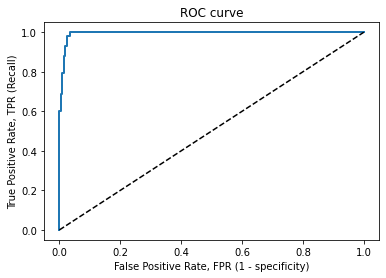

In [125]:
fpr, tpr, thresholds = roc_curve(y_valid, model.predict_proba(x_valid)[:,1], pos_label=1)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [126]:
print(classification_report(y_valid, model.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       211
           1       0.92      0.93      0.92        58

    accuracy                           0.97       269
   macro avg       0.95      0.95      0.95       269
weighted avg       0.97      0.97      0.97       269



# Стохастический градиентный спуск (Stochastic Gradient Descent SGD)

In [127]:
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(x_valid, y_valid) 
y_train_pred = cross_val_predict(sgd_clf, x_valid, y_valid, cv=3)

In [128]:
accuracy_score(y_valid, y_train_pred)

0.9405204460966543

In [129]:
np.mean(cross_val_score(sgd_clf, x_train, y_train, cv=3))

0.9617224880382776

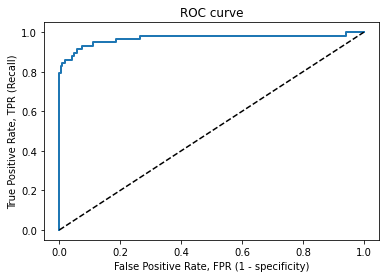

In [130]:
y_scores = cross_val_predict(sgd_clf, x_valid, y_valid, cv=3, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_valid, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

In [133]:
print(classification_report(y_valid, sgd_clf.predict(x_valid)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       211
           1       1.00      0.90      0.95        58

    accuracy                           0.98       269
   macro avg       0.99      0.95      0.97       269
weighted avg       0.98      0.98      0.98       269



# Визуализация дерева решений

In [138]:
dot_data = tree.export_graphviz(tree_grid.best_estimator_, out_file='tree.dot',filled=True)

In [139]:
!dir *png

 Том в устройстве C имеет метку Acer
 Серийный номер тома: 3C4E-9E6E

 Содержимое папки C:\Users\Alexandra\Test003\SF — копия (2)

14.11.2021  20:11            13 468 ROC.png
02.11.2021  15:37           160 351 tree.png
27.10.2021  18:28            70 822 tree1.png
               3 файлов        244 641 байт
               0 папок  21 446 631 424 байт свободно


In [140]:
!dot -Tpng tree.dot -o tree.png

"dot" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


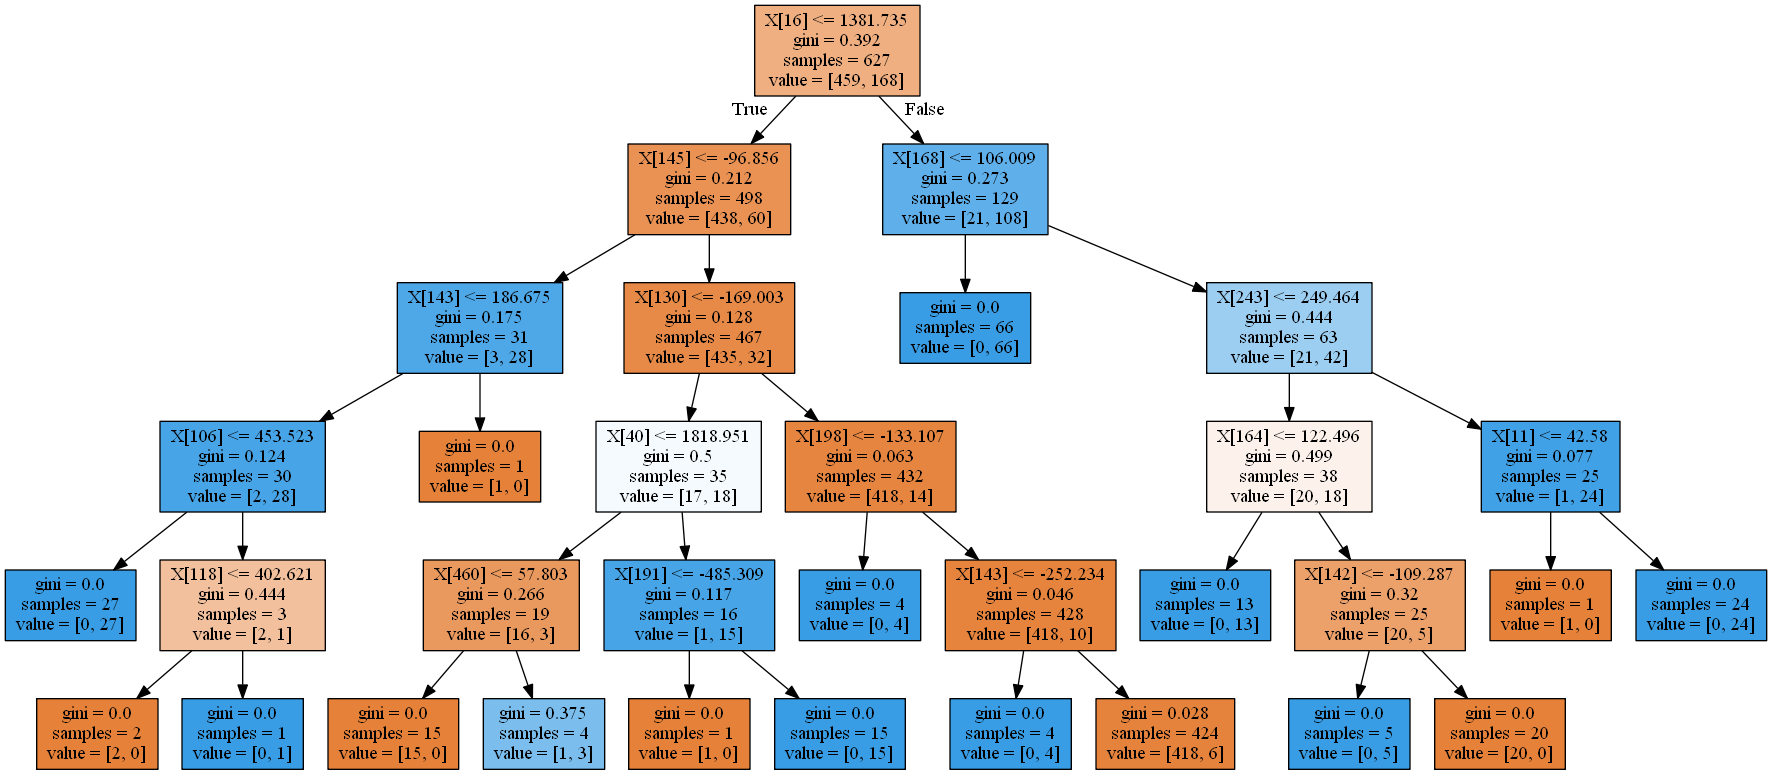

In [141]:
Image(filename='tree.png') 

# Построение кривых валидации для kNN

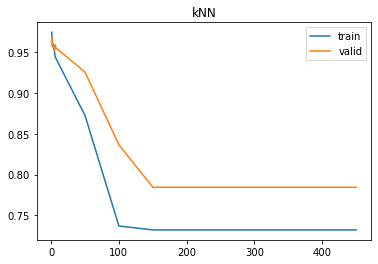

In [142]:
train_scores, valid_scores = [], []
n_neighb = [1, 2, 3, 5, 6, 7] + list(range(50, 500, 50))

for k in n_neighb:
    knn = KNeighborsClassifier(n_neighbors=k)
    train_scores.append(np.mean(cross_val_score(knn, x_train, y_train, cv=5)))
    knn.fit(x_train, y_train)
    valid_scores.append(accuracy_score(y_valid, knn.predict(x_valid)))  

plt.plot(n_neighb, train_scores, label='train')
plt.plot(n_neighb, valid_scores, label='valid')
plt.title('kNN')
plt.legend();

In [143]:
mel_basis = librosa.filters.mel(sr=22050, n_fft=512, n_mels=10,fmin=0, fmax=sr / 2)

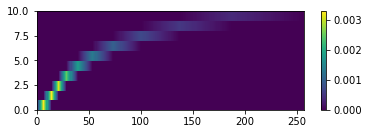

In [144]:
plt.subplot(2,1,1)
plt.pcolormesh(mel_basis)
plt.colorbar()

In [145]:
sr = 22050
mel_basis = librosa.filters.mel(sr=sr, n_fft=512, n_mels=10,fmin=0, fmax=sr / 2, htk=False, norm=None)

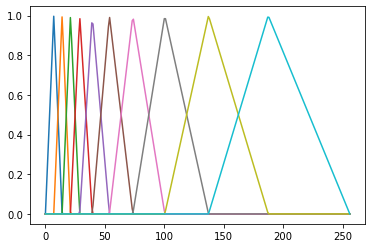

In [146]:
plt.plot(mel_basis.T)
plt.show()